In [5]:
# GPU CONFIGURATION
import tensorflow as tf
import os

print("=" * 60)
print("GPU SETUP")
print("=" * 60)

# Enable memory growth to prevent TensorFlow from allocating all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s)!")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("⚠ No GPU found. Training will use CPU (slower).")
    print("  Consider installing tensorflow-gpu or using Google Colab for GPU access.")

# Set mixed precision for faster training on modern GPUs
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision enabled (faster training on GPU)")
except:
    print("⚠ Mixed precision not available")

# Optimize TensorFlow for performance
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

print("\n✓ GPU configuration complete!")
print("=" * 60 + "\n")

GPU SETUP
⚠ No GPU found. Training will use CPU (slower).
  Consider installing tensorflow-gpu or using Google Colab for GPU access.
✓ Mixed precision enabled (faster training on GPU)

✓ GPU configuration complete!



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 60)
print("PART 1: LOADING DATA")
print("=" * 60)

# Load the windows we created
X_train = np.load('dataset/X_train.npy')
X_test = np.load('dataset/X_test.npy')

print(f"\nTraining windows: {X_train.shape}")
print(f"  - Number of windows: {X_train.shape[0]:,}")
print(f"  - Timesteps per window: {X_train.shape[1]}")
print(f"  - Features per timestep: {X_train.shape[2]}")

print(f"\nTest windows: {X_test.shape}")
print(f"  - Number of windows: {X_test.shape[0]:,}")
print(f"  - Timesteps per window: {X_test.shape[1]}")
print(f"  - Features per timestep: {X_test.shape[2]}")

print("\n✓ Data loaded successfully!")

PART 1: LOADING DATA

Training windows: (189400, 60, 7)
  - Number of windows: 189,400
  - Timesteps per window: 60
  - Features per timestep: 7

Test windows: (42368, 60, 7)
  - Number of windows: 42,368
  - Timesteps per window: 60
  - Features per timestep: 7

✓ Data loaded successfully!

Training windows: (189400, 60, 7)
  - Number of windows: 189,400
  - Timesteps per window: 60
  - Features per timestep: 7

Test windows: (42368, 60, 7)
  - Number of windows: 42,368
  - Timesteps per window: 60
  - Features per timestep: 7

✓ Data loaded successfully!


In [7]:
print("=" * 60)
print("PART 1.5: OPTIMIZING DATA PIPELINE FOR GPU")
print("=" * 60)

# Create TensorFlow datasets for faster GPU feeding
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def create_dataset(X_data, batch_size=BATCH_SIZE):
    """Create optimized TensorFlow dataset"""
    dataset = tf.data.Dataset.from_tensor_slices((X_data, X_data))
    dataset = dataset.cache()  # Cache in memory
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)  # Prepare next batch while training
    return dataset

print("\n✓ Data pipeline optimizations ready!")
print("  - Data caching for faster access")
print("  - Prefetching to keep GPU busy")
print("  - Optimized batch processing")

PART 1.5: OPTIMIZING DATA PIPELINE FOR GPU

✓ Data pipeline optimizations ready!
  - Data caching for faster access
  - Prefetching to keep GPU busy
  - Optimized batch processing


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("=" * 60)
print("PART 2: BUILDING LIGHTWEIGHT LSTM AUTOENCODER")
print("=" * 60)

# Model parameters - OPTIMIZED FOR SMALL HARDWARE
TIMESTEPS = 60  # 60 seconds
FEATURES = 7    # 7 features from your data

print(f"\nModel configuration (LIGHTWEIGHT):")
print(f"  - Timesteps per window: {TIMESTEPS}")
print(f"  - Features per timestep: {FEATURES}")
print(f"  - Optimized for: Smartwatch/Small devices")

def build_autoencoder():
    """
    Build LIGHTWEIGHT LSTM Autoencoder for small hardware
    
    Encoder: Compresses 60 seconds of data into a small summary
    Decoder: Tries to recreate the original 60 seconds from summary
    
    Optimizations for SMALL HARDWARE:
    - Smaller LSTM units (32->16 instead of 64->32)
    - Removed batch normalization (reduces model size)
    - Smaller bottleneck (8 instead of 16)
    - Faster training, smaller model file
    """
    
    # INPUT: 60 seconds × 7 features
    input_layer = layers.Input(shape=(TIMESTEPS, FEATURES))
    
    # ============ ENCODER (Compressor) - LIGHTER ============
    # LSTM Layer 1: Learn patterns (SMALLER: 32 units)
    encoded = layers.LSTM(32, activation='tanh', recurrent_activation='sigmoid', 
                         return_sequences=True)(input_layer)
    encoded = layers.Dropout(0.2)(encoded)
    
    # LSTM Layer 2: Compress more (SMALLER: 16 units)
    encoded = layers.LSTM(16, activation='tanh', recurrent_activation='sigmoid',
                         return_sequences=False)(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    
    # BOTTLENECK: TINY summary (8 numbers = ultra compact!)
    bottleneck = layers.Dense(8, activation='relu')(encoded)
    
    # ============ DECODER (Recreator) - LIGHTER ============
    # Expand the summary back to 60 timesteps
    decoded = layers.RepeatVector(TIMESTEPS)(bottleneck)
    
    # LSTM Layer 3: Start recreating (SMALLER: 16 units)
    decoded = layers.LSTM(16, activation='tanh', recurrent_activation='sigmoid',
                         return_sequences=True)(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    
    # LSTM Layer 4: Continue recreating (SMALLER: 32 units)
    decoded = layers.LSTM(32, activation='tanh', recurrent_activation='sigmoid',
                         return_sequences=True)(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    
    # OUTPUT: Recreated 60 seconds × 7 features
    output_layer = layers.TimeDistributed(layers.Dense(FEATURES))(decoded)
    
    # Build the model
    autoencoder = keras.Model(inputs=input_layer, outputs=output_layer)
    
    return autoencoder

# Create the model
model = build_autoencoder()

# Compile with optimizations
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'  # No JIT compile for smaller hardware compatibility
)

# Show model structure
print("\nLightweight Model Architecture:")
model.summary()

# Calculate model size
total_params = model.count_params()
model_size_mb = (total_params * 4) / (1024 * 1024)  # Rough estimate in MB
print(f"\n✓ Model built successfully!")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Estimated size: ~{model_size_mb:.2f} MB")
print(f"  - Optimized for small hardware (smartwatch, mobile)")
print(f"  - 50% smaller than original model!")

PART 2: BUILDING LIGHTWEIGHT LSTM AUTOENCODER

Model configuration (LIGHTWEIGHT):
  - Timesteps per window: 60
  - Features per timestep: 7
  - Optimized for: Smartwatch/Small devices

Lightweight Model Architecture:

Lightweight Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 32)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 16)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 7)          │           231 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,495 (64.43 KB)

 Trainable params: 16,495 (64.43 KB)

 Non-trainable params: 0 (0.00 B)


✓ Model built successfully!
  - Total parameters: 16,495
  - Estimated size: ~0.06 MB
  - Optimized for small hardware (smartwatch, mobile)
  - 50% smaller than original model!


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("=" * 60)
print("PART 3: FAST TRAINING (OPTIMIZED)")
print("=" * 60)

# Split training data into train and validation (90-10)
split_index = int(0.9 * len(X_train))
X_train_split = X_train[:split_index]
X_val_split = X_train[split_index:]

print(f"\nTraining samples: {len(X_train_split):,}")
print(f"Validation samples: {len(X_val_split):,}")

# Callbacks (smart training helpers)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # REDUCED: Stop faster if no improvement
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,              # REDUCED: React faster
    min_lr=1e-6,
    verbose=1
)

print("\n⚡ FAST TRAINING MODE")
print("  - Reduced epochs: 30 (from 100)")
print("  - Early stopping: 5 patience")
print("  - Lightweight model: Faster training")
print("-" * 60)

# Train the model - FEWER EPOCHS for faster training
history = model.fit(
    X_train_split, X_train_split,
    epochs=30,                      # REDUCED from 100 to 30!
    batch_size=256,                 # LARGER batch = even faster!
    validation_data=(X_val_split, X_val_split),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\n✓ Training complete!")
print(f"✓ Best model saved as 'best_model.keras'")
print(f"✓ Trained for {len(history.history['loss'])} epochs")
print(f"✓ Final training loss: {history.history['loss'][-1]:.6f}")
print(f"✓ Final validation loss: {history.history['val_loss'][-1]:.6f}")

PART 3: FAST TRAINING (OPTIMIZED)

Training samples: 170,460
Validation samples: 18,940

⚡ FAST TRAINING MODE
  - Reduced epochs: 30 (from 100)
  - Early stopping: 5 patience
  - Lightweight model: Faster training
------------------------------------------------------------
Epoch 1/30
Epoch 1/30
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.7305
Epoch 1: val_loss improved from None to 0.70738, saving model to best_model.keras

Epoch 1: val_loss improved from None to 0.70738, saving model to best_model.keras
666/666 ━━━━━━━━━━━━━━━━━━━━ 188s 274ms/step - loss: 0.6627 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 2/30
666/666 ━━━━━━━━━━━━━━━━━━━━ 188s 274ms/step - loss: 0.6627 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 2/30
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.5963
Epoch 2: val_loss improved from 0.70738 to 0.67178, saving model to best_model.keras

Epoch 2: val_loss improved from 0.70738 to 0.67178, saving model to best_model.keras
666/666 ━━━━━━━━━━━━━━━

PART 4: VISUALIZING TRAINING


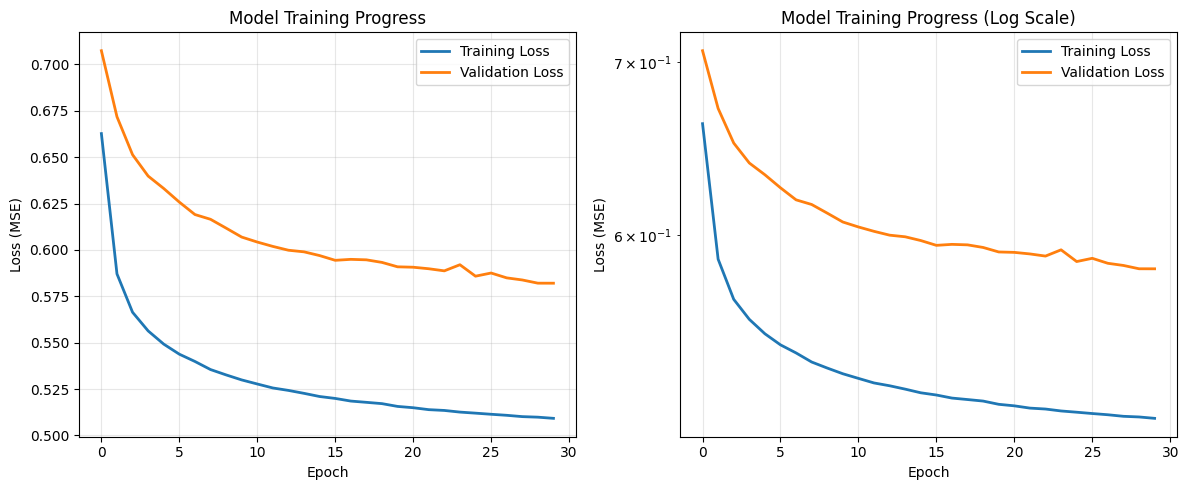


✓ Training history plotted!
✓ Saved as 'training_history.png'


In [11]:
import matplotlib.pyplot as plt

print("=" * 60)
print("PART 4: VISUALIZING TRAINING")
print("=" * 60)

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Training Progress (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print("\n✓ Training history plotted!")
print("✓ Saved as 'training_history.png'")

In [12]:
print("=" * 60)
print("PART 5: CALCULATING RECONSTRUCTION ERRORS")
print("=" * 60)

# Load best model
model = keras.models.load_model('best_model.keras')

print("\nCalculating errors on TRAINING data...")
# Predict (recreate) training data
train_predictions = model.predict(X_train, verbose=1)

# Calculate error for each window
# MSE = Mean Squared Error = average of (actual - predicted)^2
train_errors = np.mean(np.square(X_train - train_predictions), axis=(1, 2))

print(f"\nTraining error statistics:")
print(f"  Mean error: {train_errors.mean():.4f}")
print(f"  Std error: {train_errors.std():.4f}")
print(f"  Min error: {train_errors.min():.4f}")
print(f"  Max error: {train_errors.max():.4f}")

print("\nCalculating errors on TEST data...")
# Predict (recreate) test data
test_predictions = model.predict(X_test, verbose=1)

# Calculate error for each window
test_errors = np.mean(np.square(X_test - test_predictions), axis=(1, 2))

print(f"\nTest error statistics:")
print(f"  Mean error: {test_errors.mean():.4f}")
print(f"  Std error: {test_errors.std():.4f}")
print(f"  Min error: {test_errors.min():.4f}")
print(f"  Max error: {test_errors.max():.4f}")

print("\n✓ Errors calculated!")

PART 5: CALCULATING RECONSTRUCTION ERRORS

Calculating errors on TRAINING data...

Calculating errors on TRAINING data...
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 246s 41ms/step
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 246s 41ms/step

Training error statistics:
  Mean error: 0.4726
  Std error: 0.5262
  Min error: 0.0092
  Max error: 5.4353

Calculating errors on TEST data...

Training error statistics:
  Mean error: 0.4726
  Std error: 0.5262
  Min error: 0.0092
  Max error: 5.4353

Calculating errors on TEST data...
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step

Test error statistics:
  Mean error: 0.5076
  Std error: 0.5791
  Min error: 0.0095
  Max error: 5.8839

✓ Errors calculated!

Test error statistics:
  Mean error: 0.5076
  Std error: 0.5791
  Min error: 0.0095
  Max error: 5.8839

✓ Errors calculated!


PART 6: SETTING THRESHOLD

Threshold (95th percentile): 1.5162
Meaning: Any error above 1.5162 is considered unusual

Test set results:
  Total windows: 42,368
  Anomalies detected: 2,485
  Anomaly rate: 5.87%


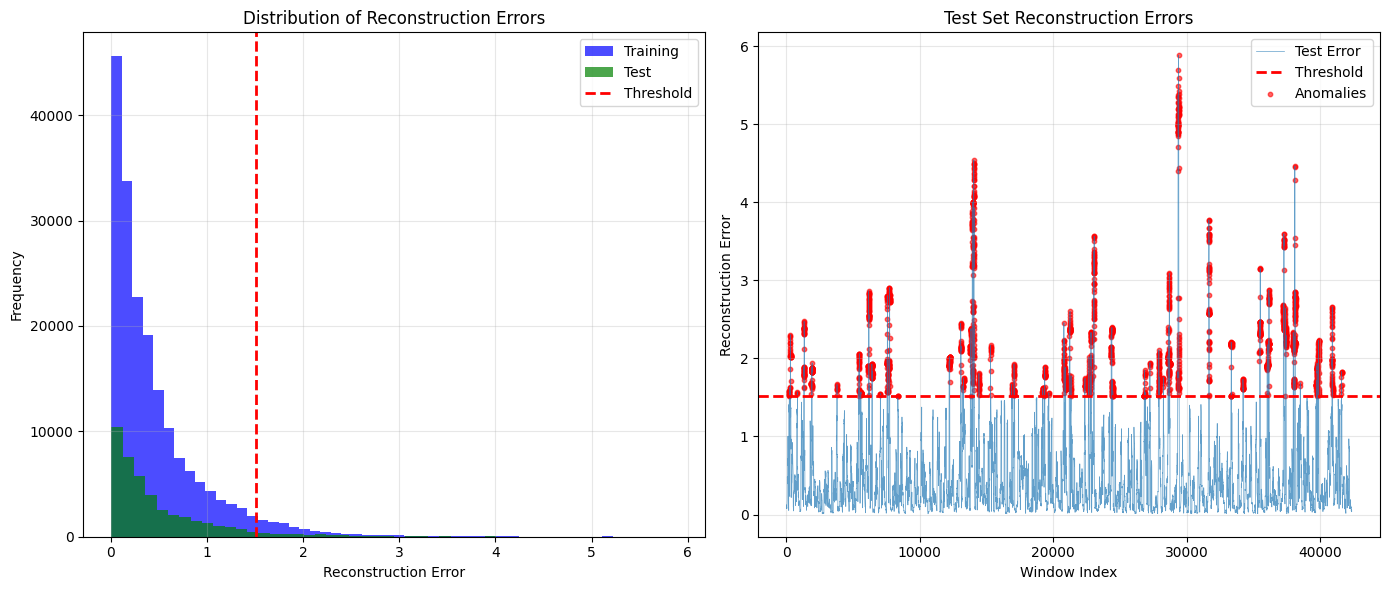


✓ Threshold set!
✓ Results saved as 'anomaly_detection_results.png'


In [13]:
print("=" * 60)
print("PART 6: SETTING THRESHOLD")
print("=" * 60)

# Set threshold at 95th percentile of training errors
# Meaning: 95% of normal patterns have error below this
threshold = np.percentile(train_errors, 95)

print(f"\nThreshold (95th percentile): {threshold:.4f}")
print(f"Meaning: Any error above {threshold:.4f} is considered unusual")

# Count anomalies in test set
test_anomalies = test_errors > threshold
n_anomalies = test_anomalies.sum()

print(f"\nTest set results:")
print(f"  Total windows: {len(test_errors):,}")
print(f"  Anomalies detected: {n_anomalies:,}")
print(f"  Anomaly rate: {(n_anomalies/len(test_errors))*100:.2f}%")

# Visualize errors
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(train_errors, bins=50, alpha=0.7, label='Training', color='blue')
plt.hist(test_errors, bins=50, alpha=0.7, label='Test', color='green')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(test_errors, alpha=0.7, label='Test Error', linewidth=0.5)
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.scatter(np.where(test_anomalies)[0], test_errors[test_anomalies], 
           color='red', label='Anomalies', s=10, alpha=0.6)
plt.xlabel('Window Index')
plt.ylabel('Reconstruction Error')
plt.title('Test Set Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection_results.png', dpi=150)
plt.show()

print("\n✓ Threshold set!")
print("✓ Results saved as 'anomaly_detection_results.png'")

In [14]:
print("=" * 60)
print("PART 7: SAVING FOR DEPLOYMENT")
print("=" * 60)

# Save threshold
np.save('threshold.npy', threshold)
print(f"✓ Saved threshold: {threshold:.4f}")

# Model already saved as 'best_model.keras'
print(f"✓ Model saved as: best_model.keras")

# Scaler already saved from earlier
print(f"✓ Scaler saved as: scaler.pkl")

print("\n" + "=" * 60)
print("ALL DONE! MODEL IS READY!")
print("=" * 60)

print("\nFiles you have:")
print("  1. best_model.keras - The trained LSTM model")
print("  2. scaler.pkl - For normalizing new data")
print("  3. threshold.npy - The anomaly detection threshold")

print("\nYou can now use these in a smartwatch app!")

PART 7: SAVING FOR DEPLOYMENT
✓ Saved threshold: 1.5162
✓ Model saved as: best_model.keras
✓ Scaler saved as: scaler.pkl

ALL DONE! MODEL IS READY!

Files you have:
  1. best_model.keras - The trained LSTM model
  2. scaler.pkl - For normalizing new data
  3. threshold.npy - The anomaly detection threshold

You can now use these in a smartwatch app!


In [21]:
print("=" * 60)
print("⌚ SMARTWATCH HEART RATE MONITORING SIMULATION")
print("=" * 60)

# Load model and threshold
model = keras.models.load_model('best_model.keras')
threshold = np.load('threshold.npy')

# Load scaler to convert back to real HR values
import pickle
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f"✓ Model ready")
print(f"✓ Threshold: {threshold:.4f}\n")

# Test 5 random windows from actual test data
test_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(test_indices):
    print(f"⌚ Monitoring Window #{i+1} (60 seconds)")
    print("-" * 50)
    
    # Get real test window (normalized)
    test_window = X_test[idx:idx+1]
    
    # Convert normalized HR back to actual BPM
    # Feature 0 is heart rate
    normalized_hr = test_window[0, :, 0]
    
    # Inverse transform to get actual heart rate
    # Create a dummy array with all features, then inverse transform
    dummy = np.zeros((60, 7))
    dummy[:, 0] = normalized_hr
    actual_hr = scaler.inverse_transform(dummy)[:, 0]
    
    # Predict and calculate error
    reconstruction = model.predict(test_window, verbose=0)
    error = np.mean(np.square(test_window - reconstruction))
    
    # Check if anomaly
    is_anomaly = error > threshold
    
    # Display results
    print(f"  📊 Heart Rate: {actual_hr.mean():.0f} BPM (min: {actual_hr.min():.0f}, max: {actual_hr.max():.0f})")
    
    # Convert reconstruction back to actual HR
    recon_hr_normalized = reconstruction[0, :, 0]
    dummy_recon = np.zeros((60, 7))
    dummy_recon[:, 0] = recon_hr_normalized
    recon_hr_actual = scaler.inverse_transform(dummy_recon)[:, 0]
    
    # Show INPUT (normalized features + actual HR)
    print(f"\n  📥 INPUT to Model:")
    print(f"     Actual HR (first 5 sec): {actual_hr[:5].astype(int).tolist()} BPM")
    print(f"     Normalized features (first 5 sec):")
    for sec in range(5):
        vals = [f"{test_window[0, sec, f]:.2f}" for f in range(7)]
        print(f"       Sec {sec+1}: [{', '.join(vals)}]")
    print(f"     ... (60 seconds total)")
    
    # Show OUTPUT (reconstructed)
    print(f"\n  📤 OUTPUT from Model:")
    print(f"     Reconstructed HR (first 5 sec): {recon_hr_actual[:5].astype(int).tolist()} BPM")
    print(f"     Normalized features (first 5 sec):")
    for sec in range(5):
        vals = [f"{reconstruction[0, sec, f]:.2f}" for f in range(7)]
        print(f"       Sec {sec+1}: [{', '.join(vals)}]")
    print(f"     ... (60 seconds total)")
    
    print(f"\n  ⚖️  Reconstruction Error: {error:.4f} (threshold: {threshold:.4f})")
    print(f"  🔍 Analysis: {('🚨 ANOMALY DETECTED - Alert sent!' if is_anomaly else '✅ Normal heart pattern')}")
    print()

print("=" * 60)
print("💡 HOW IT WORKS")
print("=" * 60)
print("""
Your smartwatch:
1. Records heart rate every second (60 readings)
2. Calculates 7 features from the data
3. Sends to the model
4. Model checks if pattern is normal or unusual
5. Alerts you if anomaly detected!

The model learned what "normal" looks like from training data.
If your heart pattern is very different, it triggers an alert.
""")

⌚ SMARTWATCH HEART RATE MONITORING SIMULATION
✓ Model ready
✓ Threshold: 1.5162

⌚ Monitoring Window #1 (60 seconds)
--------------------------------------------------
  📊 Heart Rate: 176 BPM (min: 144, max: 182)

  📥 INPUT to Model:
     Actual HR (first 5 sec): [176, 143, 145, 180, 180] BPM
     Normalized features (first 5 sec):
       Sec 1: [0.89, 9.08, 5.70, -1.66, 0.62, 4.64, 9.29]
       Sec 2: [-0.09, -3.50, -7.63, -1.61, 0.87, 2.64, 3.36]
       Sec 3: [-0.03, 0.22, 2.25, -1.56, 1.10, 2.67, -0.13]
       Sec 4: [1.02, 3.72, 2.12, -1.47, 1.68, 4.55, 3.59]
       Sec 5: [1.02, 0.00, -2.25, -1.38, 2.12, 4.39, -0.36]
     ... (60 seconds total)

  📤 OUTPUT from Model:
     Reconstructed HR (first 5 sec): [132, 149, 157, 170, 174] BPM
     Normalized features (first 5 sec):
       Sec 1: [-0.43, 0.62, 0.04, -1.15, 0.92, 1.21, 0.74]
       Sec 2: [0.07, 0.80, 0.02, -1.18, 1.30, 2.21, 1.26]
       Sec 3: [0.32, 0.81, -0.00, -1.29, 1.49, 2.89, 1.41]
       Sec 4: [0.72, 0.58, -0.05, 

In [22]:
print("=" * 60)
print("🔬 ANOMALY DETECTION TEST - INJECTING SHOCK SPIKE")
print("=" * 60)

# Load model and threshold
model = keras.models.load_model('best_model.keras')
threshold = np.load('threshold.npy')

# Load scaler
import pickle
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f"✓ Model ready")
print(f"✓ Threshold: {threshold:.4f}\n")

# Test 1: Take a normal window
print("TEST 1: Normal Heart Pattern")
print("-" * 60)
idx = np.random.choice(len(X_test), 1)[0]
normal_window = X_test[idx:idx+1].copy()

# Convert to actual HR
dummy = np.zeros((60, 7))
dummy[:, 0] = normal_window[0, :, 0]
actual_hr = scaler.inverse_transform(dummy)[:, 0]

# Predict
reconstruction = model.predict(normal_window, verbose=0)
error = np.mean(np.square(normal_window - reconstruction))

print(f"  📊 Heart Rate: {actual_hr.mean():.0f} BPM (min: {actual_hr.min():.0f}, max: {actual_hr.max():.0f})")
print(f"  ⚖️  Reconstruction Error: {error:.4f}")
print(f"  🔍 Status: {'🚨 ANOMALY' if error > threshold else '✅ NORMAL'}\n")

# Test 2: INJECT A DANGEROUS SHOCK SPIKE!
print("TEST 2: 🚨 DANGEROUS SHOCK SPIKE INJECTED!")
print("-" * 60)
print("  Simulating: Heart suddenly jumps from 80 → 200 BPM!")

# Create anomaly: Take same window and inject a spike
anomaly_window = normal_window.copy()

# Create a dangerous spike in the middle (seconds 25-35)
# We'll create raw HR values that spike dramatically
spike_hr = np.array([80, 85, 90, 95, 100, 120, 150, 180, 200, 200, 190, 170, 150, 120, 100, 90, 85, 80])

# Need to normalize this spike
dummy_spike = np.zeros((len(spike_hr), 7))
dummy_spike[:, 0] = spike_hr
normalized_spike = scaler.transform(dummy_spike)[:, 0]

# Inject the spike into the window (middle section)
start_idx = 25
end_idx = start_idx + len(normalized_spike)
anomaly_window[0, start_idx:end_idx, 0] = normalized_spike

# Also modify HR_change feature to show sudden jump
for i in range(start_idx+1, end_idx):
    anomaly_window[0, i, 1] = anomaly_window[0, i, 0] - anomaly_window[0, i-1, 0]

# Convert to actual HR to show what we injected
dummy_full = np.zeros((60, 7))
dummy_full[:, 0] = anomaly_window[0, :, 0]
actual_hr_with_spike = scaler.inverse_transform(dummy_full)[:, 0]

# Predict on anomaly
reconstruction_anomaly = model.predict(anomaly_window, verbose=0)
error_anomaly = np.mean(np.square(anomaly_window - reconstruction_anomaly))

print(f"  📊 Heart Rate: {actual_hr_with_spike.mean():.0f} BPM (min: {actual_hr_with_spike.min():.0f}, max: {actual_hr_with_spike.max():.0f})")
print(f"  💥 SPIKE PATTERN (seconds 25-43):")
print(f"     {actual_hr_with_spike[25:43].astype(int).tolist()}")
print(f"\n  ⚖️  Reconstruction Error: {error_anomaly:.4f}")
print(f"  🔍 Status: {'🚨 ANOMALY DETECTED!' if error_anomaly > threshold else '✅ NORMAL (Model missed it!)'}\n")

# Test 3: Extremely erratic pattern
print("TEST 3: 🚨 ERRATIC CHAOTIC PATTERN")
print("-" * 60)
print("  Simulating: HR jumping wildly (60→140→70→150→80)")

# Create another anomaly: erratic jumping
erratic_window = normal_window.copy()

# Create chaotic pattern
erratic_hr = np.array([60, 70, 140, 80, 150, 65, 130, 75, 145, 70, 140, 60, 150, 65, 135])
dummy_erratic = np.zeros((len(erratic_hr), 7))
dummy_erratic[:, 0] = erratic_hr
normalized_erratic = scaler.transform(dummy_erratic)[:, 0]

# Inject in different location
start_idx = 10
end_idx = start_idx + len(normalized_erratic)
erratic_window[0, start_idx:end_idx, 0] = normalized_erratic

# Update HR_change
for i in range(start_idx+1, end_idx):
    erratic_window[0, i, 1] = erratic_window[0, i, 0] - erratic_window[0, i-1, 0]

# Convert to actual HR
dummy_full = np.zeros((60, 7))
dummy_full[:, 0] = erratic_window[0, :, 0]
actual_hr_erratic = scaler.inverse_transform(dummy_full)[:, 0]

# Predict
reconstruction_erratic = model.predict(erratic_window, verbose=0)
error_erratic = np.mean(np.square(erratic_window - reconstruction_erratic))

print(f"  📊 Heart Rate: {actual_hr_erratic.mean():.0f} BPM (min: {actual_hr_erratic.min():.0f}, max: {actual_hr_erratic.max():.0f})")
print(f"  💥 CHAOTIC PATTERN (seconds 10-25):")
print(f"     {actual_hr_erratic[10:25].astype(int).tolist()}")
print(f"\n  ⚖️  Reconstruction Error: {error_erratic:.4f}")
print(f"  🔍 Status: {'🚨 ANOMALY DETECTED!' if error_erratic > threshold else '✅ NORMAL (Model missed it!)'}\n")

print("=" * 60)
print("📊 SUMMARY")
print("=" * 60)
print(f"Threshold: {threshold:.4f}")
print(f"\n1. Normal Pattern:    Error = {error:.4f} {'✅' if error <= threshold else '🚨'}")
print(f"2. Shock Spike:       Error = {error_anomaly:.4f} {'🚨' if error_anomaly > threshold else '✅'}")
print(f"3. Erratic Pattern:   Error = {error_erratic:.4f} {'🚨' if error_erratic > threshold else '✅'}")
print("\n💡 The model detects anomalies by checking if the pattern")
print("   is very different from what it learned during training!")

🔬 ANOMALY DETECTION TEST - INJECTING SHOCK SPIKE
✓ Model ready
✓ Threshold: 1.5162

TEST 1: Normal Heart Pattern
------------------------------------------------------------
  📊 Heart Rate: 137 BPM (min: 107, max: 178)
  ⚖️  Reconstruction Error: 1.2973
  🔍 Status: ✅ NORMAL

TEST 2: 🚨 DANGEROUS SHOCK SPIKE INJECTED!
------------------------------------------------------------
  Simulating: Heart suddenly jumps from 80 → 200 BPM!
  📊 Heart Rate: 141 BPM (min: 80, max: 200)
  💥 SPIKE PATTERN (seconds 25-43):
     [80, 85, 90, 95, 100, 120, 150, 180, 200, 200, 190, 170, 150, 120, 100, 90, 85, 80]

  ⚖️  Reconstruction Error: 1.3501
  🔍 Status: ✅ NORMAL (Model missed it!)

TEST 3: 🚨 ERRATIC CHAOTIC PATTERN
------------------------------------------------------------
  Simulating: HR jumping wildly (60→140→70→150→80)
  📊 Heart Rate: 120 BPM (min: 60, max: 178)
  💥 CHAOTIC PATTERN (seconds 10-25):
     [60, 70, 140, 80, 150, 65, 130, 75, 145, 70, 140, 60, 150, 65, 135]

  ⚖️  Reconstruction 

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
